In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
import chart_studio.plotly as py
cf.go_offline()

## Data Collection and Data Manipulation

In [2]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [3]:
goog = get_finance_data('goog')

In [4]:
goog

,Open,High,Low,Close,Volume
Date,,,,,
2009-02-02,166.520844,171.855835,165.380112,169.649109,10452833
2009-02-03,170.645386,170.859573,166.291702,169.589340,13162151
2009-02-04,169.400040,176.558212,168.951721,170.859573,13685907
2009-02-05,169.818481,177.026459,167.870773,176.199554,14583258
2009-02-06,177.564438,186.207047,177.056351,184.946777,14128961
...,...,...,...,...,...
2021-10-15,2844.000000,2844.000000,2821.290039,2833.500000,1062500
2021-10-18,2824.270020,2859.975098,2824.270020,2859.209961,828200
2021-10-19,2865.830078,2882.139893,2861.919922,2876.439941,765800


In [5]:
goog_close = goog[['Close']]

## Data Visualization

In [6]:
goog_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

In [7]:
goog['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

# Time Series Data

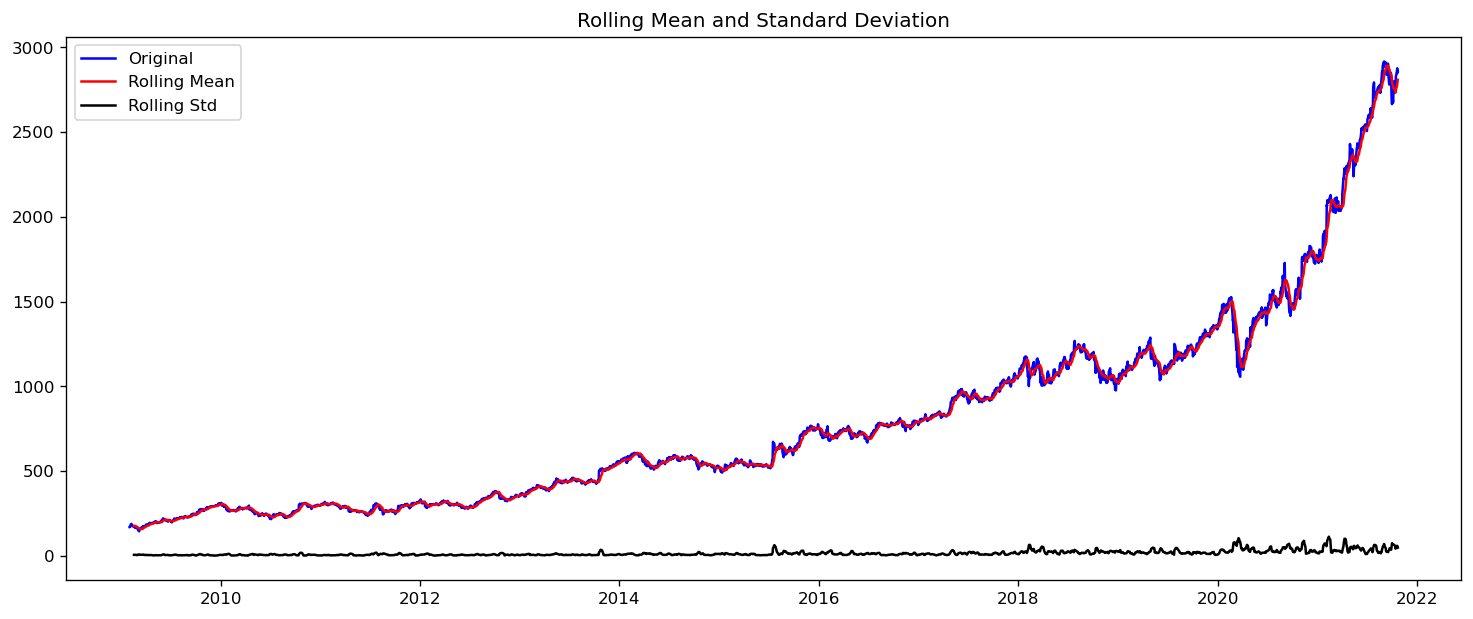

Results of dickey fuller test
Test Statistics                   4.279873
p-value                           1.000000
No. of lags used                 26.000000
Number of observations used    3177.000000
critical value (1%)              -3.432410
critical value (5%)              -2.862450
critical value (10%)             -2.567255
dtype: float64


In [32]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(goog_close)

<Figure size 1800x720 with 0 Axes>

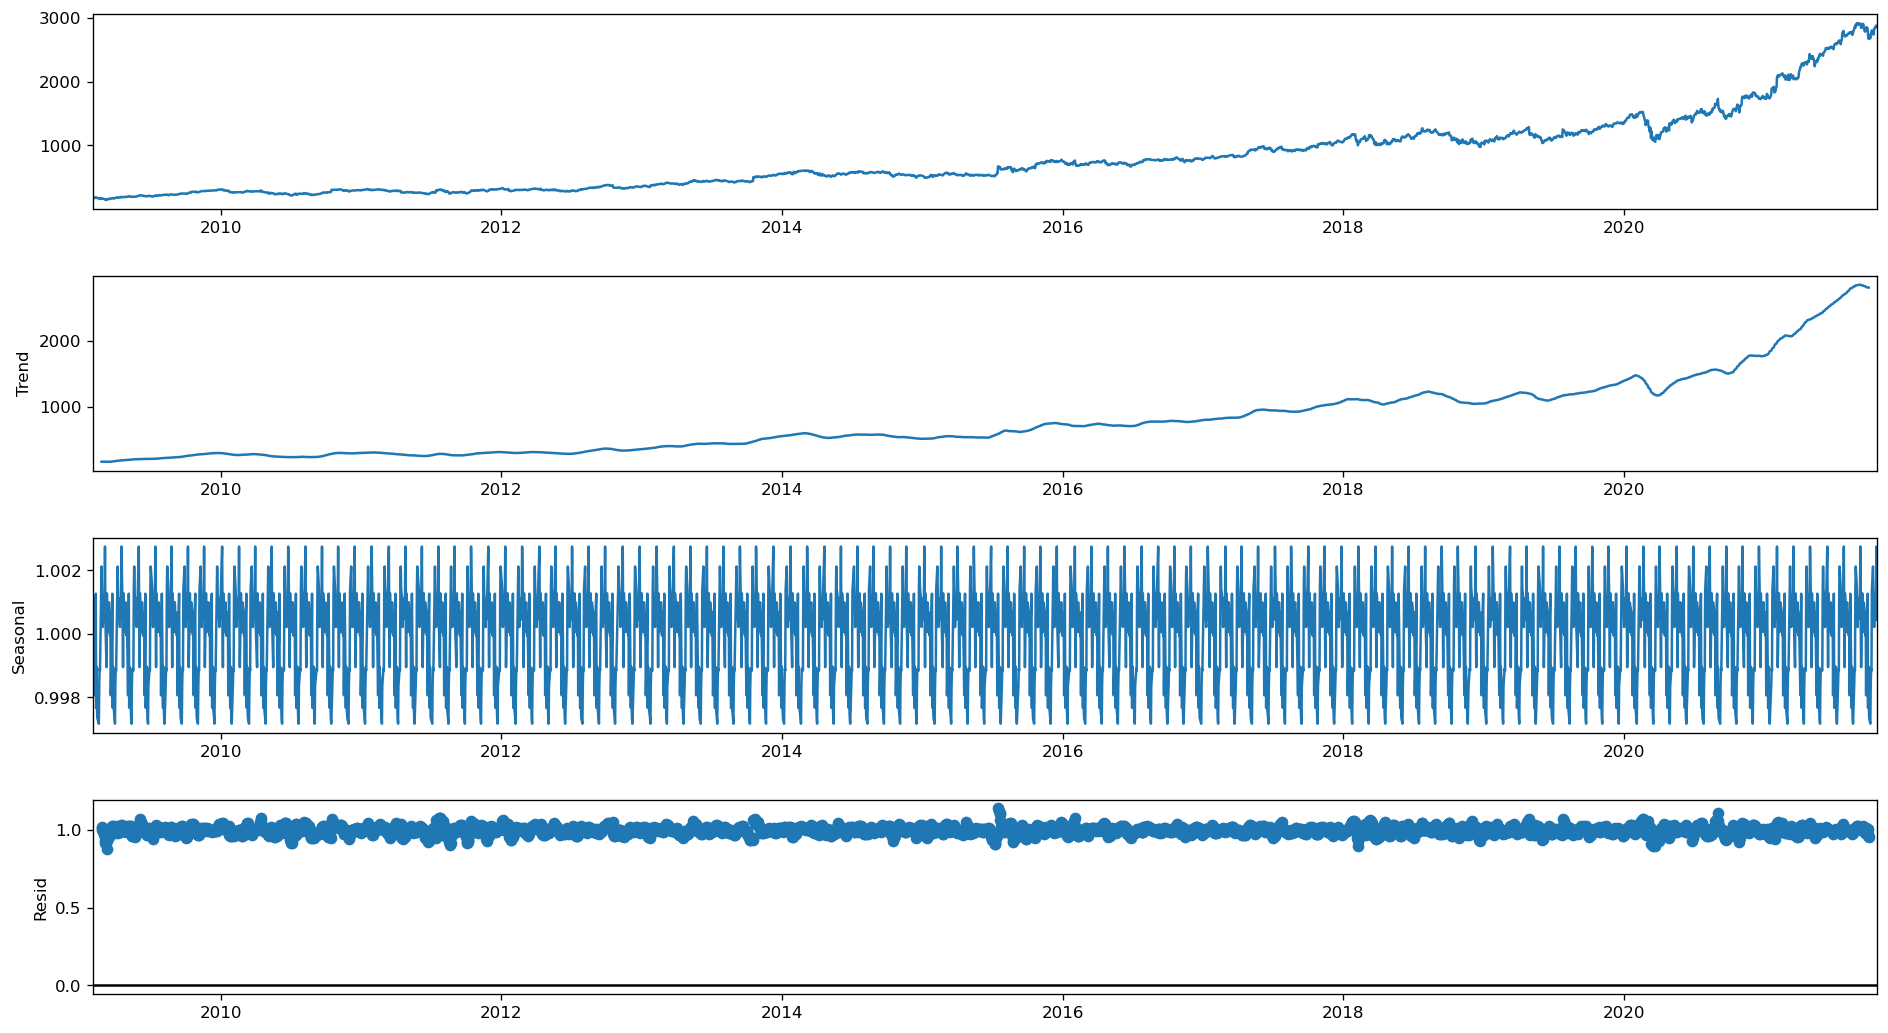

In [33]:
result = seasonal_decompose(goog_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Time Series Data Manipulation

In [8]:
goog_close

,Close
Date,
2009-02-02,169.649109
2009-02-03,169.589340
2009-02-04,170.859573
2009-02-05,176.199554
2009-02-06,184.946777
...,...
2021-10-15,2833.500000
2021-10-18,2859.209961
2021-10-19,2876.439941


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(goog_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 4.279873
p-value: 1.000000


## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

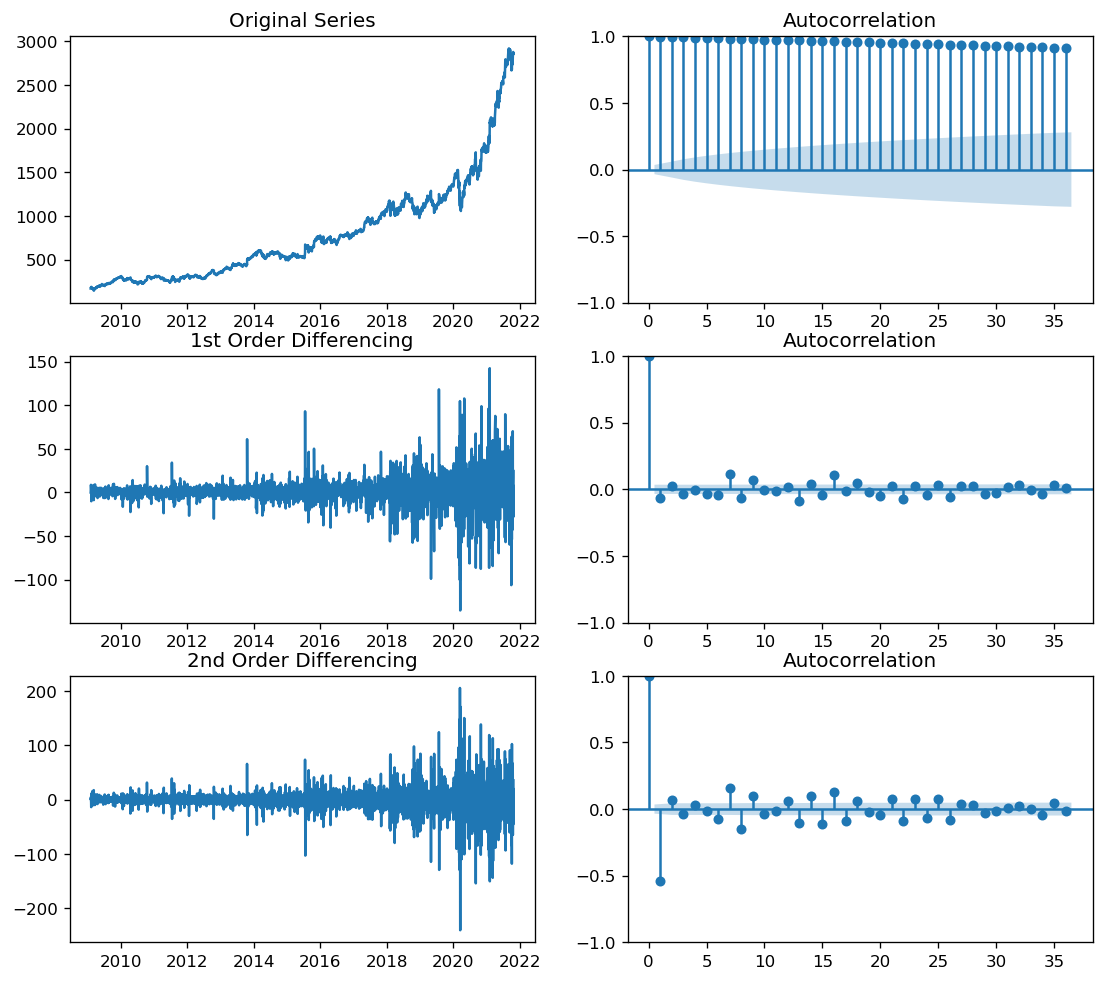

In [10]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(goog_close); axes[0, 0].set_title('Original Series')
plot_acf(goog_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(goog_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(goog_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(goog_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(goog_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced

## AR term (p)

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



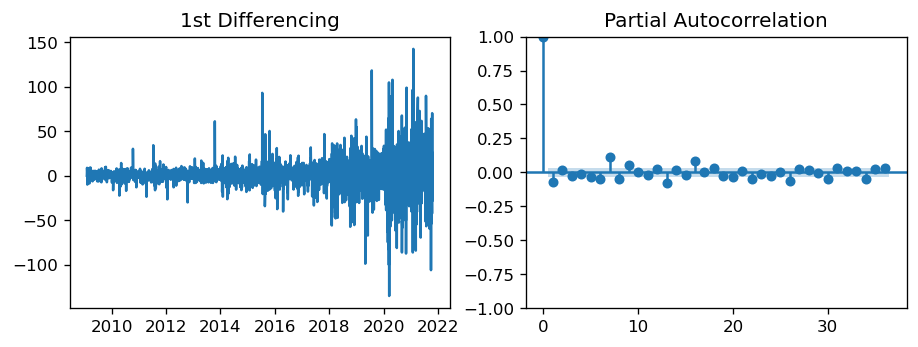

In [11]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(goog_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(goog_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significant since is well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

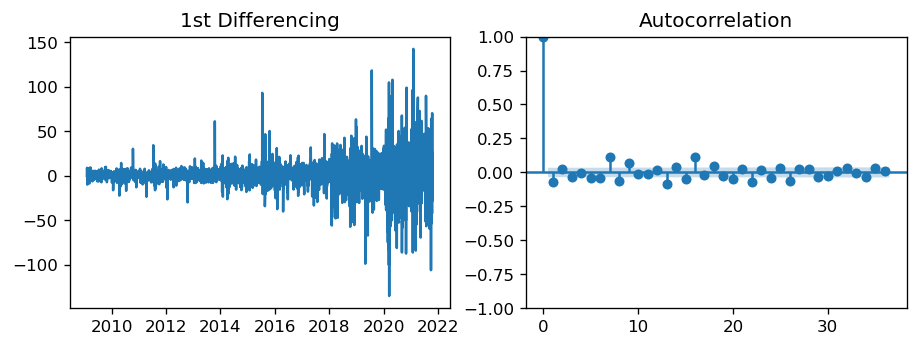

In [12]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(goog_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(goog_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# ARIMA

## Train-Test Split

In [13]:
n = int(len(goog_close) * 0.80)
train = goog_close[:n]
test = goog_close[n:]

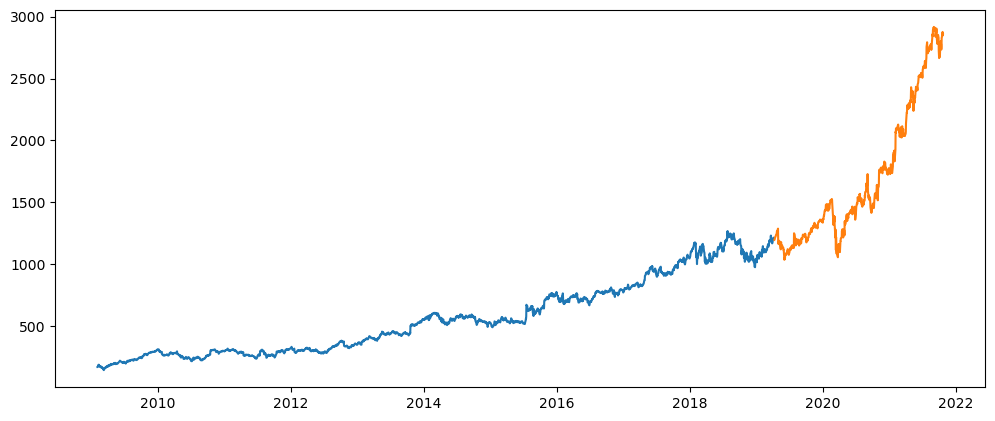

In [14]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [15]:
model = SARIMAX(goog_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3204
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -13357.293
Date:                Wed, 27 Oct 2021   AIC                          26720.587
Time:                        15:06:07   BIC                          26738.802
Sample:                             0   HQIC                         26727.117
                               - 3204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4512      0.085     -5.304      0.000      -0.618      -0.284
ma.L1          0.3873      0.087      4.440      0.000       0.216       0.558
sigma2       245.3495      2.188    112.152      0.0

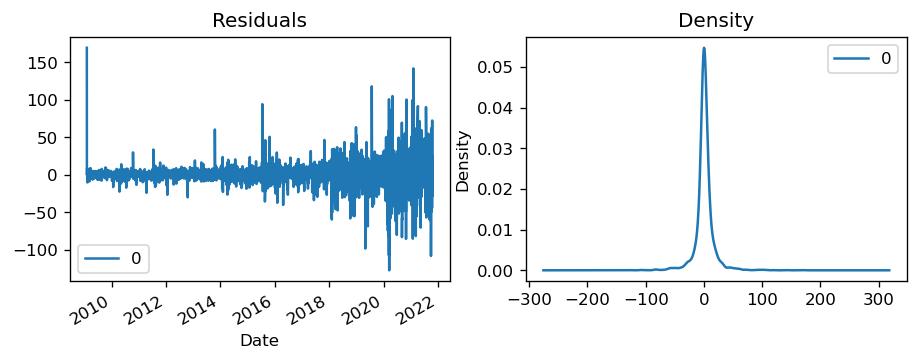

In [16]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [17]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), end=pd.to_datetime('2021-10-21'), dynamic=False)
plt.show()

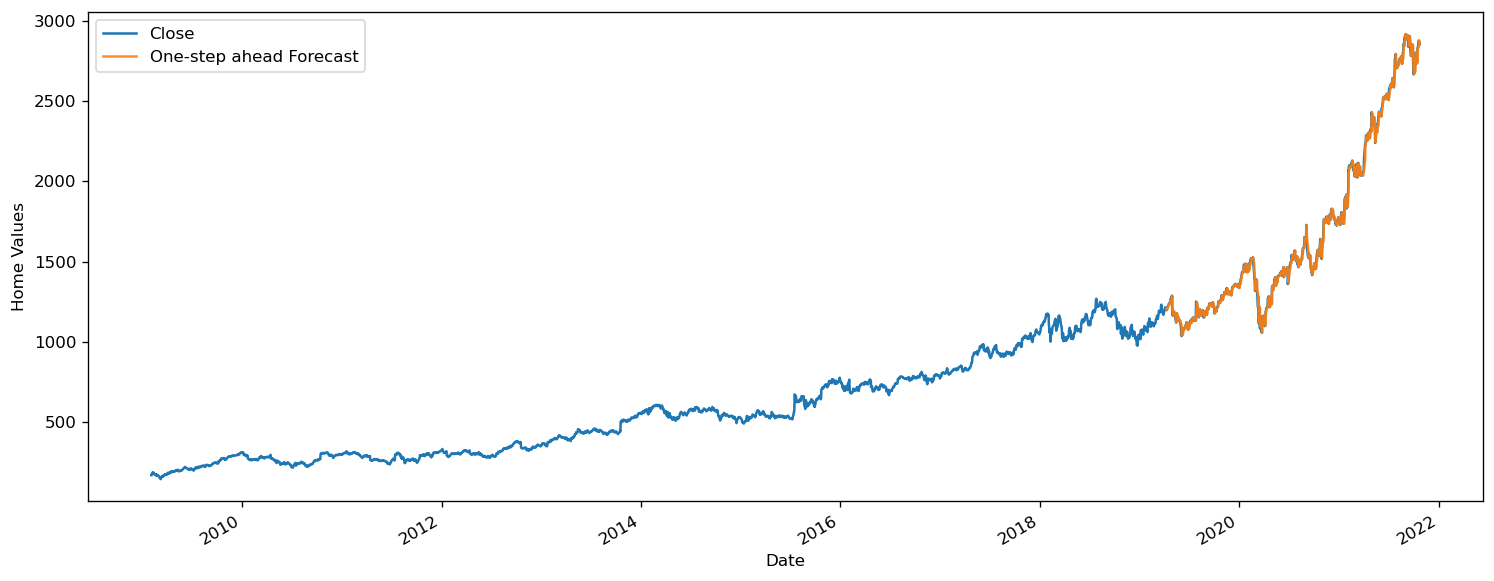

In [18]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = goog_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();

In [19]:
value_forecasted = pred
value_truth = goog_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 29.43


# PMDARIMA

In [20]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [21]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [22]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18763.713, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18764.764, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18764.670, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18766.419, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18761.908, Time=2.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18762.499, Time=2.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18762.508, Time=5.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18761.187, Time=1.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=18762.739, Time=1.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18764.508, Time=8.73 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=18764.140, Time=0.53 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 31.601 seconds


In [23]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2563
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -9376.593
Date:                Wed, 27 Oct 2021   AIC                          18761.187
Time:                        15:06:41   BIC                          18784.581
Sample:                             0   HQIC                         18769.669
                               - 2563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4062      0.183      2.216      0.027       0.047       0.766
ma.L1          0.0215      0.011      1.893      0.058      -0.001       0.044
ma.L2         -0.0474      0.011     -4.122      0.0

In [24]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 875.982430734285
SMAPE: 1.271196560225924


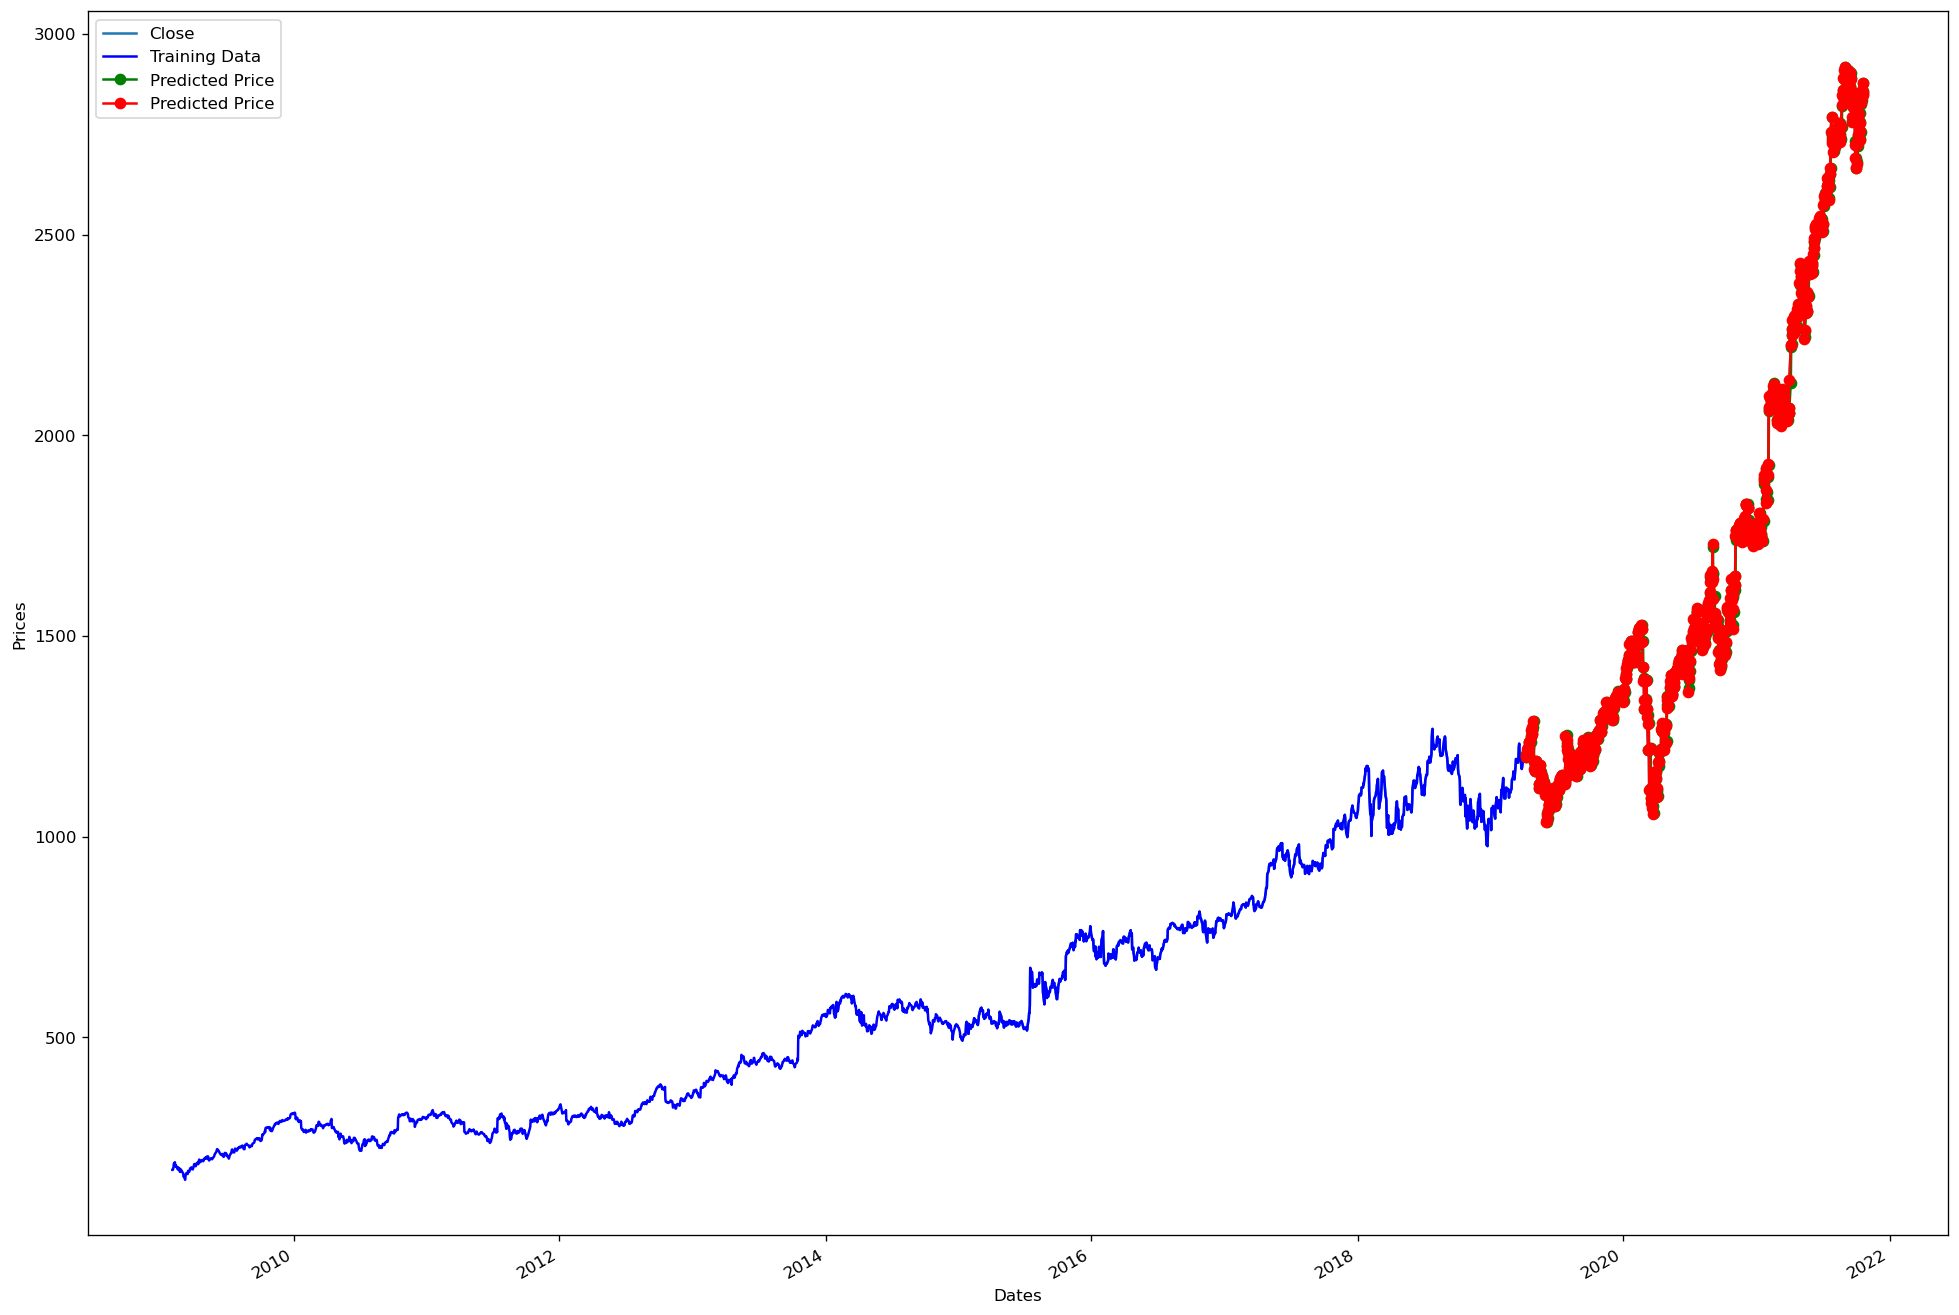

In [26]:
ax = goog_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [25]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(875.982430734285), 2)))

The Root Mean Squared Error of prediction is 29.6


## SARIMAX PMDARIMA

In [27]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=20.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=24492.724, Time=0.29 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=19708.174, Time=6.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=22197.139, Time=8.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=24557.387, Time=0.21 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=20355.866, Time=0.89 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=19328.470, Time=31.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=56.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=19.51 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=24460.761, Time=26.28 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=19323.390, Time=41.27 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=19703.755, Time=9.66 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=65.22 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=16.99 sec
 ARIMA(3,0,0)(2,1,0)[12] in

In [28]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 1154.5185668402291
SMAPE: 1.5072421468153698


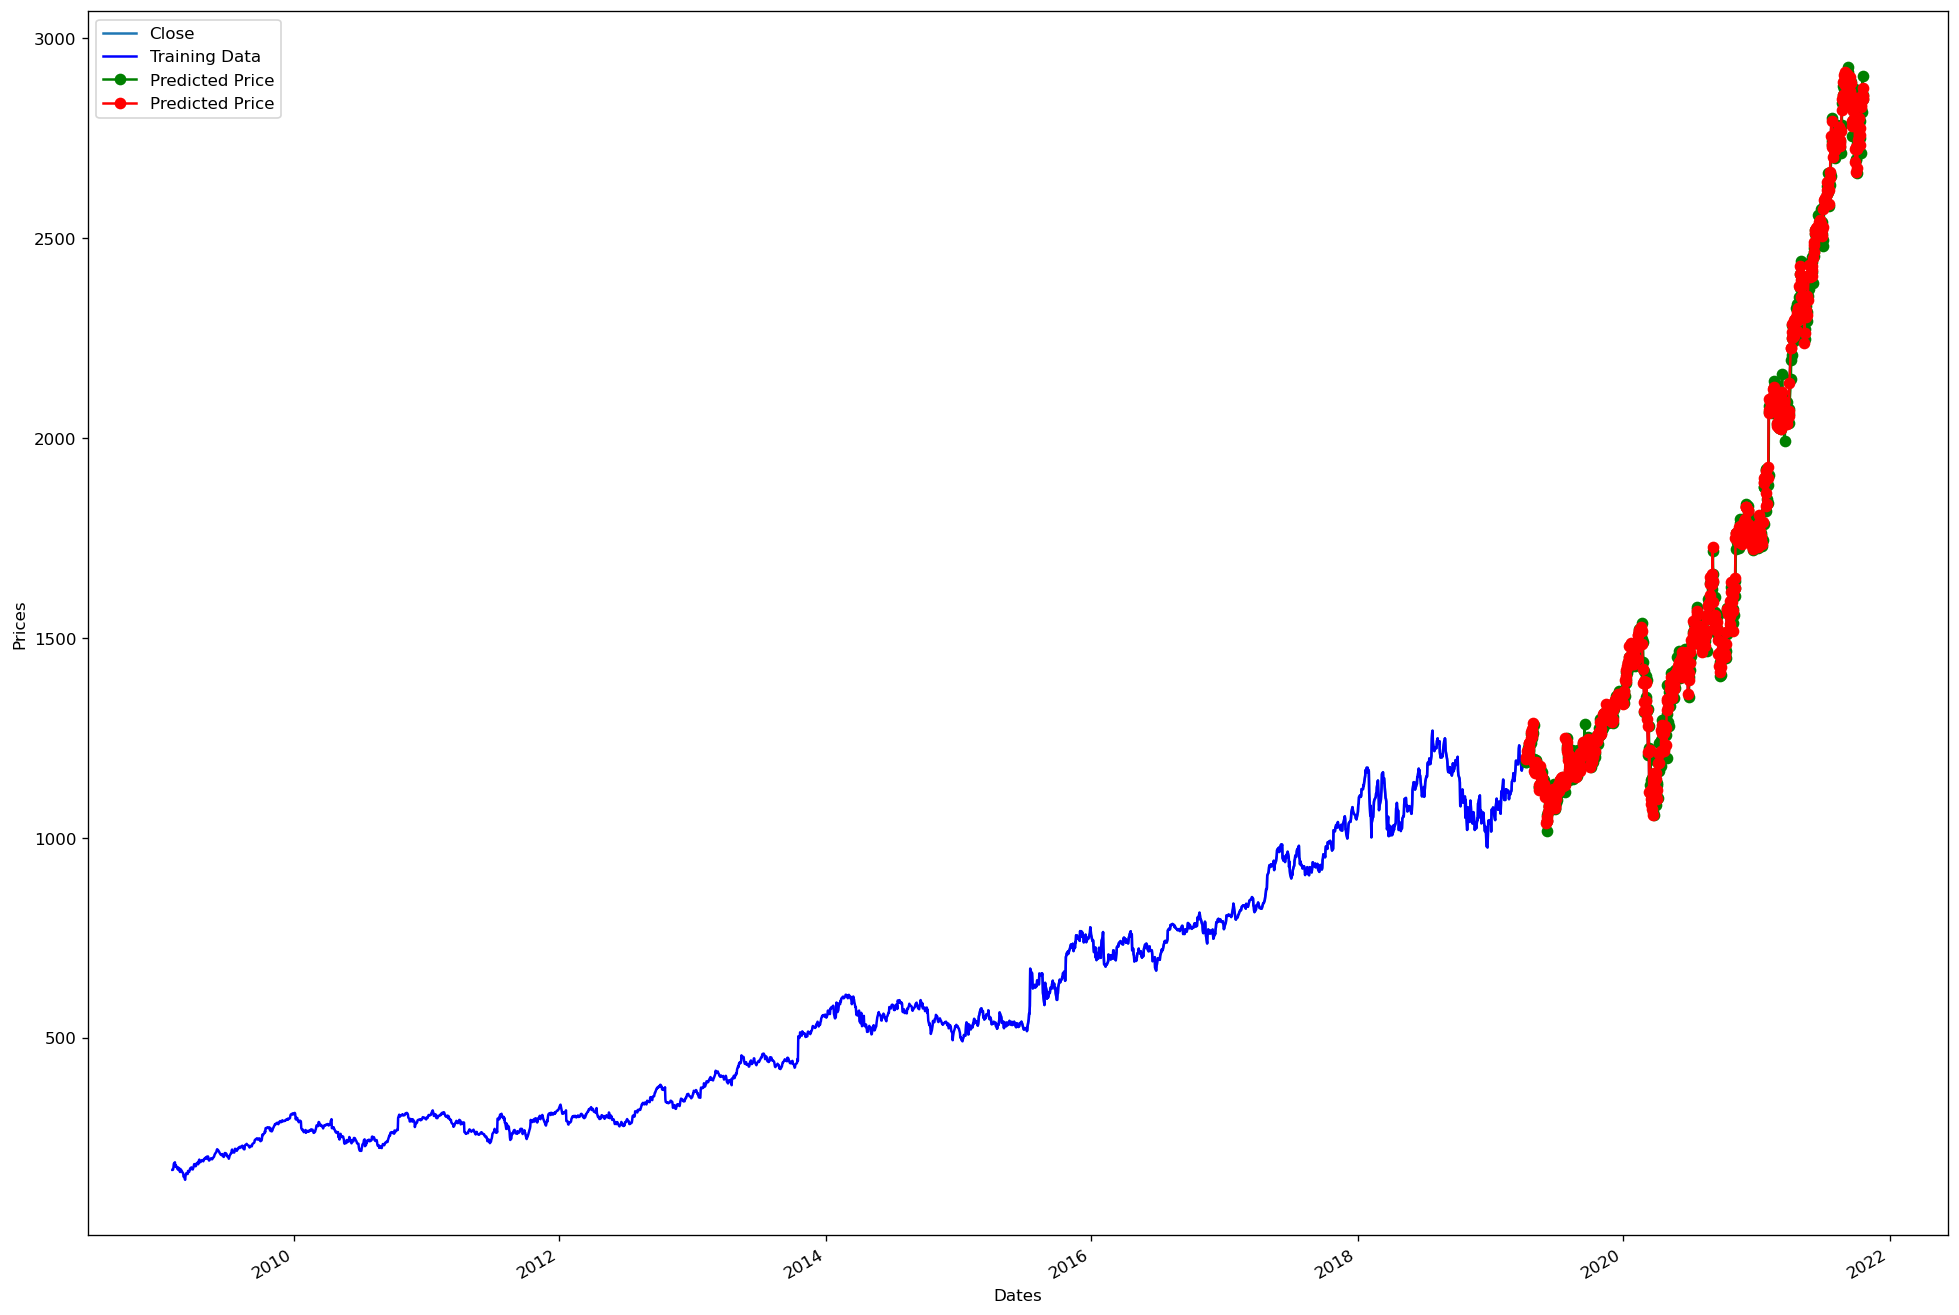

In [29]:
ax = goog_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [31]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(1154.5185668402291), 2)))

The Root Mean Squared Error of prediction is 33.98


## FBPROPHET

In [34]:
goog_close =goog[['Close']]

In [35]:
goog = goog_close.reset_index()

In [36]:
goog.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
goog['ds'] = pd.to_datetime(goog['ds'])
goog['y']=goog['y'].astype(float)

In [37]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)
df_prophet.fit(goog)

In [38]:

fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

,ds
3559,2022-10-12
3560,2022-10-13
3561,2022-10-14
3562,2022-10-15
3563,2022-10-16
3564,2022-10-17
3565,2022-10-18
3566,2022-10-19
3567,2022-10-20
3568,2022-10-21


In [39]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [40]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3564,2022-10-17,3160.779773,2955.930151,3345.989653
3565,2022-10-18,3163.275970,2950.265312,3340.552745
3566,2022-10-19,3165.871568,2966.268409,3362.851987
3567,2022-10-20,3167.648958,2966.726407,3356.105374
3568,2022-10-21,3169.793299,2964.975435,3358.612250


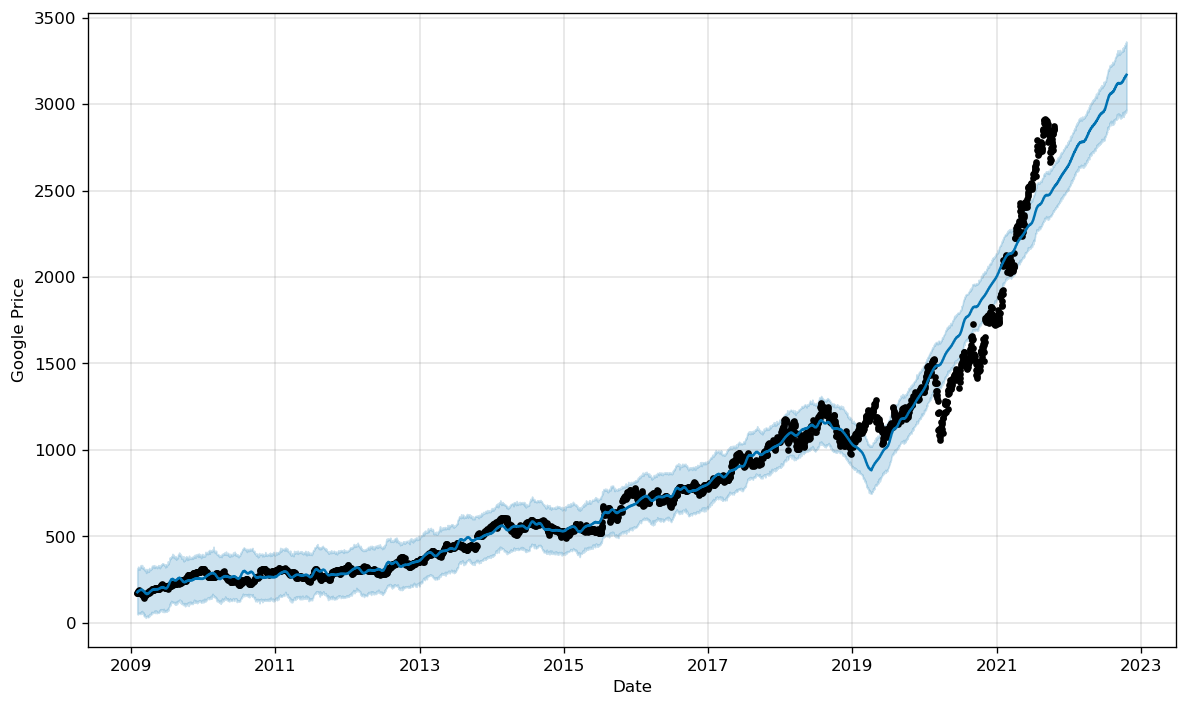

In [41]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Google Price');

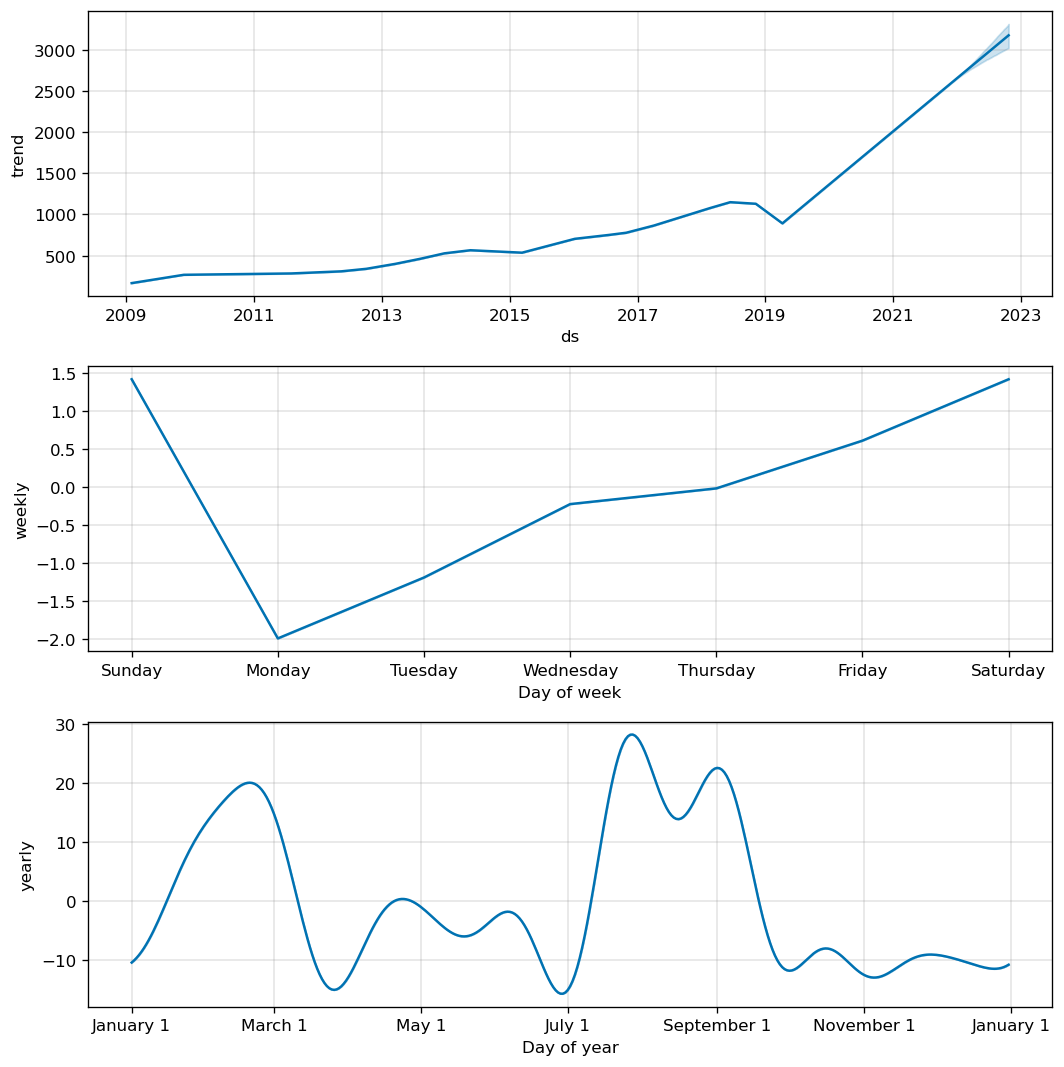

In [42]:

fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In [43]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 18 forecasts with cutoffs between 2012-04-23 12:00:00 and 2020-10-21 00:00:00
100%|██████████| 18/18 [03:09<00:00, 10.53s/it]


In [44]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,9527.167615,97.607211,75.281888,0.091010,0.073348,0.090607,0.195638
1,37 days 00:00:00,9824.633977,99.119292,76.504654,0.092169,0.074625,0.091756,0.188053
2,37 days 12:00:00,9858.154261,99.288238,76.646834,0.092057,0.073783,0.091710,0.188369
3,38 days 00:00:00,9976.511760,99.882490,77.397699,0.093029,0.074766,0.092704,0.183312
4,38 days 12:00:00,9957.375752,99.786651,77.305914,0.092880,0.074345,0.092593,0.185525


## Result
The ARIMA model performed the best with the lowest rmse